In [1]:
import sys
sys.path.append("../")
from Functions.csv_files.stock import Stock

In [2]:
apple = Stock('AAPL.US', filepath="../Functions/csv_files/")

In [3]:
apple.retrieve_data()

,date,close,volume,3 Month Treasury Yield,WTI Crude Oil Prices,7-day volatility,7-day EWM,7-rsi,7-day slope,14-day volatility,14-day EWM,14-rsi,14-day slope
0,1980-12-12,28.7392,469033600,16.55,NaN,NaN,28.739200,NaN,NaN,NaN,28.739200,NaN,NaN
1,1980-12-15,27.2608,175884800,16.77,NaN,NaN,28.369600,NaN,NaN,NaN,28.542080,NaN,NaN
2,1980-12-16,25.2448,105728000,16.70,NaN,NaN,27.588400,NaN,NaN,NaN,28.102443,NaN,NaN
3,1980-12-17,25.8720,86441600,16.47,NaN,NaN,27.159300,NaN,NaN,NaN,27.805050,NaN,NaN
4,1980-12-18,26.6336,73449600,16.20,NaN,NaN,27.027875,NaN,NaN,NaN,27.648857,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10598,2022-12-23,131.8600,63814900,4.23,79.57,29.533940,134.509237,133.602857,-0.550000,82.490509,137.503068,138.360714,-1.040593
10599,2022-12-27,130.0300,69007800,4.35,79.45,28.367354,133.389428,132.678571,-0.518929,86.712790,136.506659,137.440714,-1.128637
10600,2022-12-28,126.0400,85438400,4.35,78.89,45.654730,131.552071,131.468571,-0.968571,97.436570,135.111104,136.376429,-1.339011
10601,2022-12-29,129.6100,75703700,4.34,78.43,46.363788,131.066553,131.074286,-1.038929,96.866017,134.377624,135.445000,-1.325516


In [4]:
def split(dataframe, window, columns = None, test_split = False):
  X = []
  y_raw = []
  y_label = []
  if columns is not None:
    dataframe = dataframe[columns]
  dataframe = dataframe.dropna()
  dataframe = dataframe.drop(columns=['date']).reset_index(drop=True)
  L = len(dataframe)
  
  for i in range(0, L):
    if i > (L - window - 1):
      break
    X.append(dataframe[i:(i + window)])
    label = dataframe['close'][i + window]
    last = dataframe['close'][i + window - 1]
    y_raw.append(label)
    if label <= last:
      y_label.append(0)
    else:
      y_label.append(1)
      
  if test_split:
    """
    We can't shuffle split here because in LSTM we are using return_sequence = True
    """
    print("Todo")
    

      
  
  return X, y_raw, y_label

In [ ]:
apple.data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10603 entries, 0 to 10602
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    10603 non-null  object 
 1   close                   10603 non-null  float64
 2   volume                  10603 non-null  int64  
 3   3 Month Treasury Yield  10503 non-null  float64
 4   WTI Crude Oil Prices    9293 non-null   float64
 5   7-day volatility        10597 non-null  float64
 6   7-day EWM               10603 non-null  float64
 7   7-rsi                   10597 non-null  float64
 8   7-day slope             10597 non-null  float64
 9   14-day volatility       10590 non-null  float64
 10  14-day EWM              10603 non-null  float64
 11  14-rsi                  10590 non-null  float64
 12  14-day slope            10590 non-null  float64
dtypes: float64(11), int64(1), object(1)
memory usage: 1.1+ MB


In [5]:
X, y_raw, y_label = split(apple.data, 7)

In [9]:

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import keras
import numpy as np
import lstm_utils
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [7]:
train_X_control = np.array(X)
train_X_control = train_X_control[:,:,0].reshape(-1, 7, 1)
train_y = np.array(y_label)
train_X_control = train_X_control.astype('float32')
train_X_control.shape

(9207, 7, 1)

In [10]:
control_model = None
try:
  control_model = keras.models.load_model("control_LSTM")
except Exception as e:
  control_model = Sequential()
  control_model.add(LSTM(units=16, return_sequences=True, input_shape=( 7, 1)))
  control_model.add(keras.layers.Dropout(0.2))
  control_model.add(LSTM(units=8))
  control_model.add(keras.layers.Dropout(0.2))
  control_model.add(Dense(1))
  control_model.compile(optimizer='adam', loss='mean_squared_error')
  control_history = control_model.fit(train_X_control, np.array(y_raw), epochs=200, verbose=1, validation_split=0.2)
  control_model.save("control_LSTM")
  

In [ ]:
lstm_utils.plot_history(control_history, title="control mode")

In [12]:
figure(figsize=(8, 6), dpi=80)
l = len(y_raw)
date = apple.data['date'].to_list()
date = date[len(date) - l:]

<Figure size 640x480 with 0 Axes>

In [16]:
predicted = control_model.predict(train_X_control)[:, 0]

288/288 [==============================] - 2s 3ms/step


In [14]:
import seaborn as sns
actual = y_raw
sns.lineplot(date, actual)

c:\Users\Admin\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot: >

Error in callback <function flush_figures at 0x0000018A030CA310> (for post_execute):


KeyboardInterrupt: 

In [15]:

plt.plot(date, actual, label = 'actual', color='red')
plt.show()


KeyboardInterrupt: 

In [17]:
plt.plot(date, predicted, label = 'predicted', color = 'green')
plt.show()

KeyboardInterrupt: 

<h1>Model 1 - 3M yield and WTI Prices</h1>

In [30]:
df = apple.data[['date', 'close', '3 Month Treasury Yield', 'WTI Crude Oil Prices']]
X, y_raw, y_label = split(df, 7)
train_X = np.array(X)
train_X = train_X.astype('float32')
train_X.shape

(9207, 7, 3)

In [31]:
train_y = np.array(y_raw)

In [41]:
model = Sequential()

model.add(LSTM(units=32, return_sequences=True, input_shape=(7, 3)))
model.add(keras.layers.Dropout(0.2))
model.add(LSTM(units=16))
model.add(keras.layers.Dropout(0.2))
model.add(Dense(8))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['acc'])

history = model.fit(train_X, train_y, epochs=30, verbose=1, validation_split=0.2)

Epoch 1/30
231/231 [==============================] - 8s 15ms/step - loss: 30965.6094 - acc: 0.0000e+00 - val_loss: 22218.7773 - val_acc: 0.0000e+00
Epoch 2/30
231/231 [==============================] - 3s 12ms/step - loss: 24530.0586 - acc: 0.0000e+00 - val_loss: 11702.4688 - val_acc: 0.0000e+00
Epoch 3/30
231/231 [==============================] - 2s 10ms/step - loss: 17877.2129 - acc: 0.0000e+00 - val_loss: 4598.5942 - val_acc: 0.0000e+00
Epoch 4/30
231/231 [==============================] - 3s 11ms/step - loss: 12173.0479 - acc: 0.0000e+00 - val_loss: 2001.7152 - val_acc: 0.0000e+00
Epoch 5/30
231/231 [==============================] - 3s 11ms/step - loss: 7676.0820 - acc: 0.0000e+00 - val_loss: 902.1193 - val_acc: 0.0000e+00
Epoch 6/30
231/231 [==============================] - 2s 10ms/step - loss: 4640.8599 - acc: 0.0000e+00 - val_loss: 1101.3837 - val_acc: 0.0000e+00
Epoch 7/30
231/231 [==============================] - 3s 11ms/step - loss: 2989.1951 - acc: 0.0000e+00 - val_loss

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


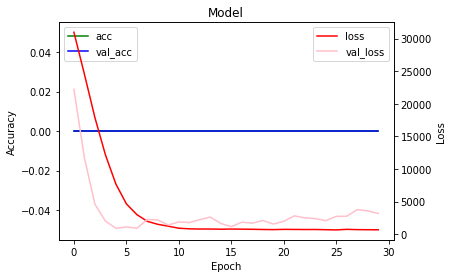

In [42]:
lstm_utils.plot_history(history, "Model")

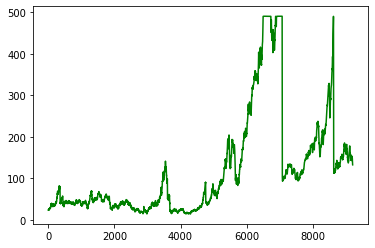

In [45]:
plt.plot(predicted, label = 'predicted', color = 'green')
plt.show()


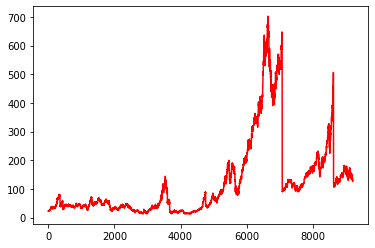

In [44]:
plt.plot(actual, label = 'actual', color='red')
plt.show()

Model 2 - 

In [63]:
df = apple.data[['date', 'close', '3 Month Treasury Yield', 'WTI Crude Oil Prices', '7-day slope', '7-rsi']]
X, y_raw, y_label = split(df, 7)
train_X = np.array(X)
train_X = train_X.astype('float32')

train_y = np.array(train_y)
train_X.shape

(9207, 7, 5)

In [65]:
model = Sequential()

model.add(LSTM(units=32, return_sequences=True, input_shape=(7, 5)))
model.add(keras.layers.Dropout(0.2))
model.add(LSTM(units=16))
model.add(keras.layers.Dropout(0.2))
model.add(Dense(8))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(train_X, train_y, epochs=30, verbose=1, validation_split=0.2)

Epoch 1/30
231/231 [==============================] - 8s 16ms/step - loss: 32037.0508 - val_loss: 24528.4316
Epoch 2/30
231/231 [==============================] - 2s 10ms/step - loss: 25873.1777 - val_loss: 13712.5674
Epoch 3/30
231/231 [==============================] - 2s 10ms/step - loss: 19091.2949 - val_loss: 5443.7988
Epoch 4/30
231/231 [==============================] - 3s 11ms/step - loss: 13027.8379 - val_loss: 2303.2800
Epoch 5/30
231/231 [==============================] - 2s 11ms/step - loss: 8201.2168 - val_loss: 974.6400
Epoch 6/30
231/231 [==============================] - 3s 11ms/step - loss: 5079.0220 - val_loss: 450.9002
Epoch 7/30
231/231 [==============================] - 3s 11ms/step - loss: 3171.4446 - val_loss: 541.5524
Epoch 8/30
231/231 [==============================] - 2s 10ms/step - loss: 2021.3577 - val_loss: 1152.7065
Epoch 9/30
231/231 [==============================] - 3s 11ms/step - loss: 1617.5538 - val_loss: 2475.6064
Epoch 10/30
231/231 [=============

dict_keys(['loss', 'val_loss'])


KeyError: 'val_acc'

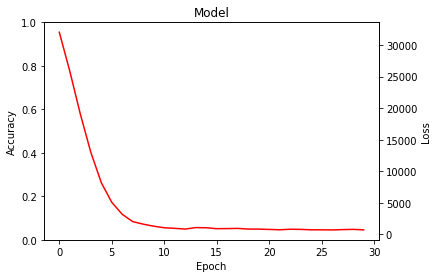

In [66]:
lstm_utils.plot_history(history, "Model")